# Population genetics 2: stochastic discrete-time models

## [Models in Population Biology](http://modelspopbiol.yoavram.com)
## Yoav Ram

In [2]:
import random

%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import scipy.stats
import sympy
sympy.init_printing()
import seaborn as sns
sns.set_context('talk')

Today we focus on **discrete-time models**.
These models can follow, for example:

- The size of an insect population in year i;
- The proportion of individuals in a population carrying a particular gene in the i-th generation;
- The number of cells in a bacterial culture on day i;
- The concentration of a toxic gas in the lung after the i-th breath;
- The concentration of drug in the blood after the i-th dose.

We will model a population with two distinct **types**, focusing on the change in the frequency of individuals in each of these types from one time point to the next.
These types can model [colored balls](https://en.wikipedia.org/wiki/Polya_urn_model), genes, product, health vs. disease, or even technologies such as USB plug types.

# Stochastic model: large population

We mentioned before that the assumption of a _very large population_ may break when either the population is small or when the number of individuals of a certain type is small.

We'll start with the later case.
In this case, the population is very large, but most of the individuals are of type $B$, whereas $A$ is initially very rare, so the dynamics of $A$ while rare are stochastic.

A common model for such dynamics is a **branching process**.

For simplicity, we assume that the number of offspring per individual is Poisson distributed, with mean $1$ for type $B$ and $1+s$ for type $A$.

So the probability that an $A$ individual leaves $k$ offspring is

$$
P(k) = e^{-(1+s)}\frac{(1+s)^k}{k!}
$$

From Otto and Day 2007 (ch. 14.5):

> The key insight made by Haldane (1927) was that the probability that a type ultimately leaves no descendants must equal the probability that each offspring produced by this type leaves no descendants.

So we can write the probability to lose type $A$ despite it's advantage over type $B$ as
$$
p_{loss} = \sum_{k=0}^{\infty}{p_{loss}^k P(k)} = \\
e^{-(1+s)} \sum_{k=0}^{\infty}{\frac{\big((1+s)p_{loss}\big)^k}{k!}} = \\
e^{-(1+s)} e^{p_{loss}(1+s)}
$$

where the last transition is due to the Taylor expansion on the exponential function.

So we get the extinction probability
$$
p_{loss} = e^{-(1-p_{loss})(1+s)}
$$
and the complement is the fixation probability, $p_{fix} = 1-p_{loss}$.

The solution to these relationship cannot be expressed using elementary functions, and in fact, the solution is called a [Lambert W function](https://en.wikipedia.org/wiki/Lambert_W_function). A good introduction for the application of Lambert W in population biology can be found in [Lehtonen 2016](https://doi.org/10.1111/2041-210X.12568).

We can find the specific Lambert W function which solves this relationship using with [SymPy](http://sympy.org), a Python framework for symbolic mathematics:

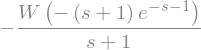

In [8]:
ploss, s = sympy.symbols('p_{loss} s')
eq = ploss - sympy.exp(-(1 - ploss) * (1 + s))
sol = sympy.solve(eq, ploss)[0]

sol

Let's plot the result:

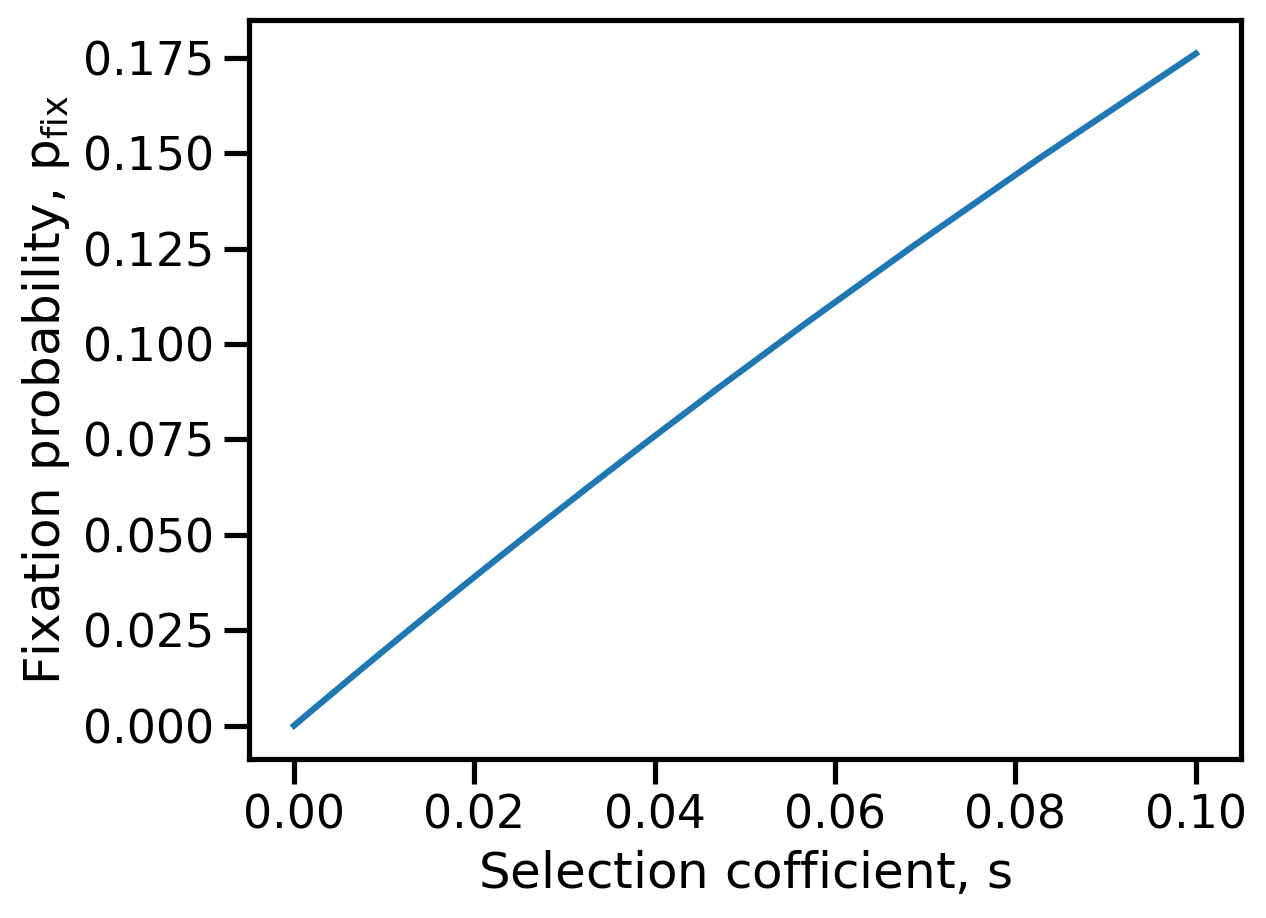

In [9]:
s = np.logspace(-5, -1)
pfix = [1 - sol.evalf(subs=dict(s=s_)) for s_ in s]

plt.plot(s, pfix)
plt.xlabel('Selection cofficient, $s$')
plt.ylabel('Fixation probability, $p_{fix}$');

We can rewrite the formula in terms of $p_{fix}=1-p_{loss}$:

$$
p_{fix} = 1-e^{-(1+s)p_{fix}} 
$$

If we assume that $s$ and $p_{fix}$ are both *small* (i.e. porportional to some small $\epsilon$), we can use the Taylor expansion for the exponential function (again) to get, up to term of order $o(\epsilon^3)$,

$$
p_{fix} \approx (1+s)p_{fix} - \frac{1}{2}\big((1+s)p_{fix}\big)^2
$$

To solve this we do some algebra and use the quadratic formula

$$
p_{fix} - (1+s)p_{fix} + \frac{1}{2}\big((1+s)p_{fix}\big)^2 = 0 \Rightarrow \\
\frac{1}{2}(1+s)^2 p_{fix}^2 -s p_{fix} = 0 \Rightarrow \\
p_{fix} = \frac{s \pm s}{(1+s)^2}
$$

So we get that $p_{fix} \approx s\frac{s}{1+s}$, and since $s$ is small, we have $p_{fix} \approx 2s$.

Let's compare it to the full result (the Lambert W function).

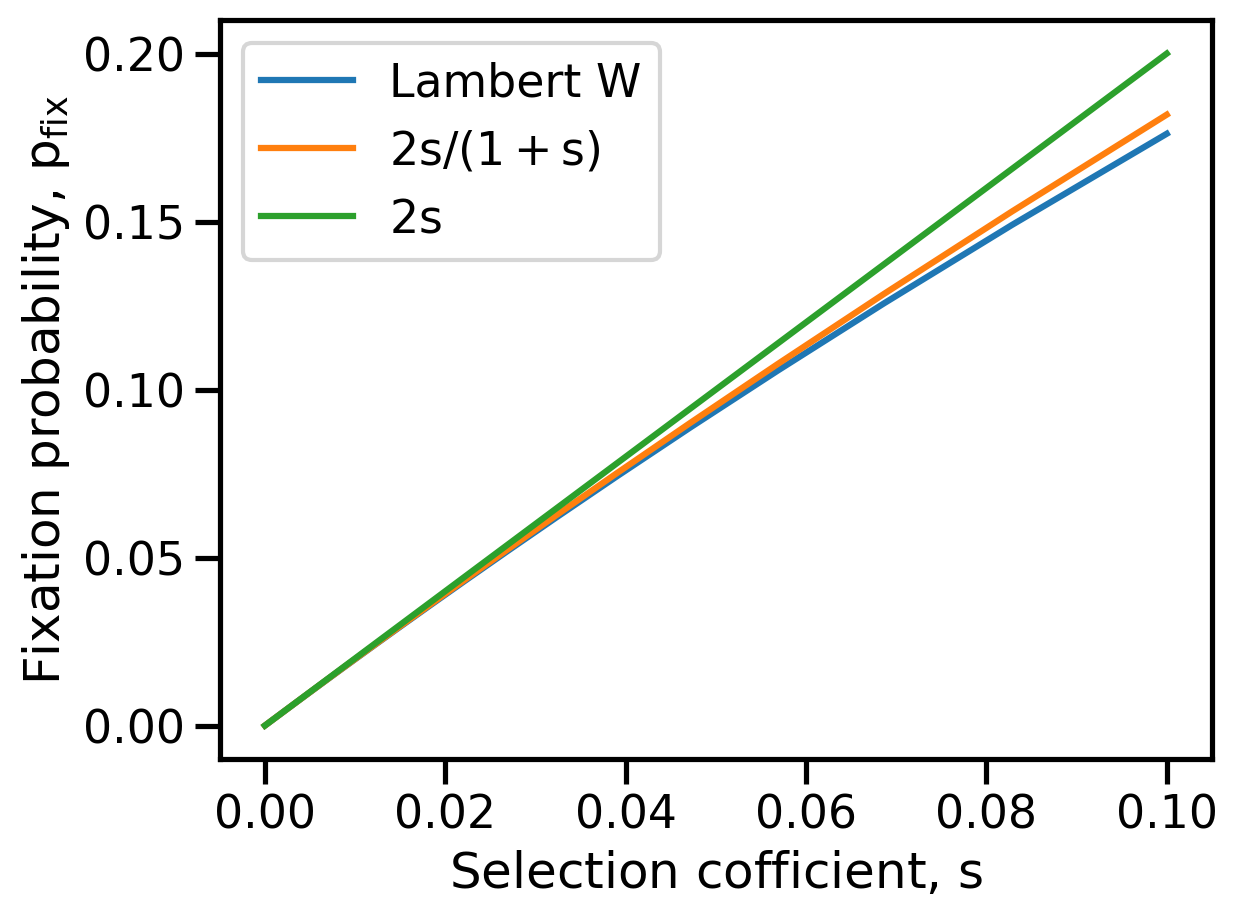

In [10]:
plt.plot(s, pfix, label='Lambert W')
plt.plot(s, 2*s/(1+s), label='$2s/(1+s)$')
plt.plot(s, 2*s, label='$2s$')
plt.xlabel('Selection cofficient, $s$')
plt.ylabel('Fixation probability, $p_{fix}$');
plt.legend();

So we can use one of the two approximations, depending on the value $s$.

# Stochastic model: small population

In a small population, random effects can affect the dynamics even when both types are common.

We will use the **Wright-Fisher model**:
at each generation the number of offspring of type $A$, which we mark $n$ , is binomially distributed $Bin(N, p)$, where $p$ is the frequency of $A$ parents.

![Sewall Wright](https://upload.wikimedia.org/wikipedia/en/8/8d/Sewall_Wright-en.jpg)

**[Sewall Wright](https://en.wikipedia.org/wiki/Sewall_Wright), 1889 - 1988**

![R.A. Fisher](https://upload.wikimedia.org/wikipedia/commons/2/21/RonaldFisher1912.jpg)

**[R.A. Fisher](https://en.wikipedia.org/wiki/Ronald_Fisher), 1890 - 1972**

## Conceptual model

Consider a population of $N$ individuals.
$p$ of the individuals are of type $A$, and $1-p$ are of type $B$.
In each reproductive cycle (generation), $A$ and $B$ individuals reproduce at a rate $1+s$ and $1$, where $s>0$ is the selection coefficient of $A$.

This is similar to an urn with $N$ balls, of which $p$ are blue and $1-p$ are red.
At each generation we fill a new urn with balls:
1. we draw a ball from the previous urn, where the odds to draw blue vs red balls is $1+s$.
1. we put a new ball in the new urn with the color of the drawn ball.
1. repeat until the new urn has $N$ balls.

In [2]:
HTML("""<script async class="speakerdeck-embed" data-id="a82ed8531523453d86f7fc09c857749e" data-ratio="1.77777777777778" src="//speakerdeck.com/assets/embed.js"></script>""")

## Pure Python implementation

First we implement the model using a pure Python function.

Of course, everytime we run the simulation we will get a different result (yay randomness).

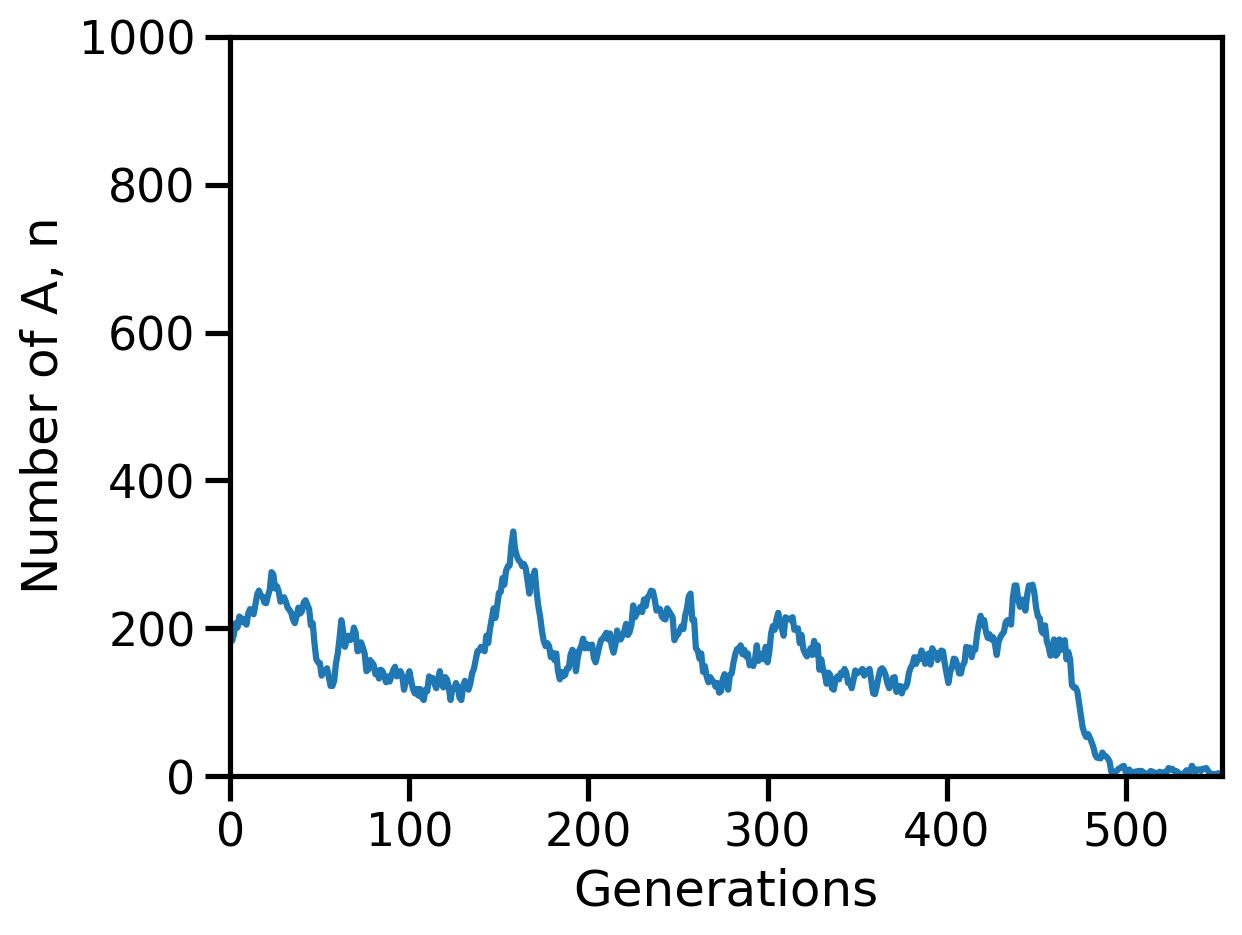

In [23]:
def simulation_py(n0, N, s):
    n = [n0]

    while 0 < n[-1] < N:
        p = n[-1] * (1 + s) / (N + n[-1] * s)
        sample = ( # generator expression
            1 
            for _ in range(N) 
            if random.random() < p
        )
        n.append(sum(sample))

    return n

n0 = 200 
N = 1000
s = 0.001

n = simulation_py(n0, N, s)

plt.plot(n)
plt.xlabel('Generations')
plt.ylabel('Number of $A$, $n$')
plt.ylim(0, N)
plt.xlim(0, len(n));

In [12]:
%timeit simulation_py(n0=200, N=1000, s=0.1)
%timeit simulation_py(n0=2000, N=10000, s=0.1)

10.7 ms ± 129 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)
142 ms ± 7.7 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


This becomes slow when $N$ is large, but we don't really care too much because when $N$ is large we can use the deterministic model.

But still, we can do faster than that using NumPy.

## NumPy implementation

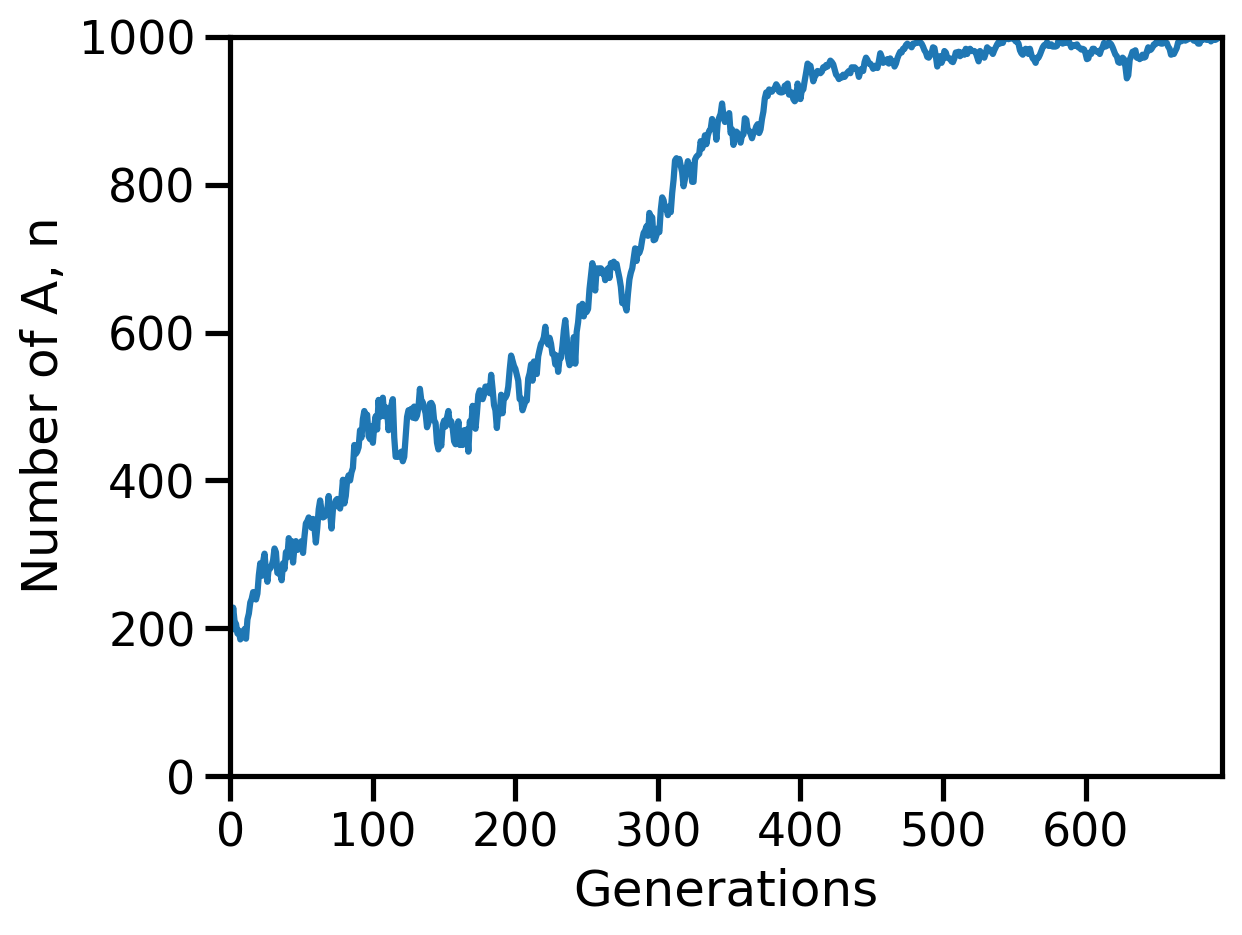

In [25]:
def simulation_np(n0, N, s, buflen=1000):
    n = np.empty(buflen)
    n[0] = n0
    t = 0
    while 0 < n[t] < N:        
        p = n[t] * (1 + s) / (N + n[t] * s)
        t += 1
        if t == len(n):
            n = np.append(n, np.empty(buflen))
        n[t] = np.random.binomial(N, p)

    return n[:t+1].copy()


n0 = 200 
N = 1000
s = 0.001

n = simulation_np(n0, N, s)

plt.plot(n)
plt.xlabel('Generations')
plt.ylabel('Number of $A$, $n$')
plt.ylim(0, N)
plt.xlim(0, len(n));

In [21]:
%timeit simulation_np(n0=200, N=1000, s=0.1)
%timeit simulation_np(n0=2000, N=10000, s=0.1)

199 µs ± 12.2 µs per loop (mean ± std. dev. of 7 runs, 1,000 loops each)
264 µs ± 6.09 µs per loop (mean ± std. dev. of 7 runs, 1,000 loops each)


This is much faster than the pure Python implementation, and the differences between population sizes is smaller.

Can we do even faster?

## Multiple simulations

Since the dynamics are random, we will want to run many replications of the simulation and collect some statistics.

### Pure Python

In [26]:
def simulations_py(n0, N, s, repetitions=10):
    return [
        simulation_py(n0, N, s) 
        for _ in range(repetitions)
    ]

n = simulations_py(n0, N, s, 100)

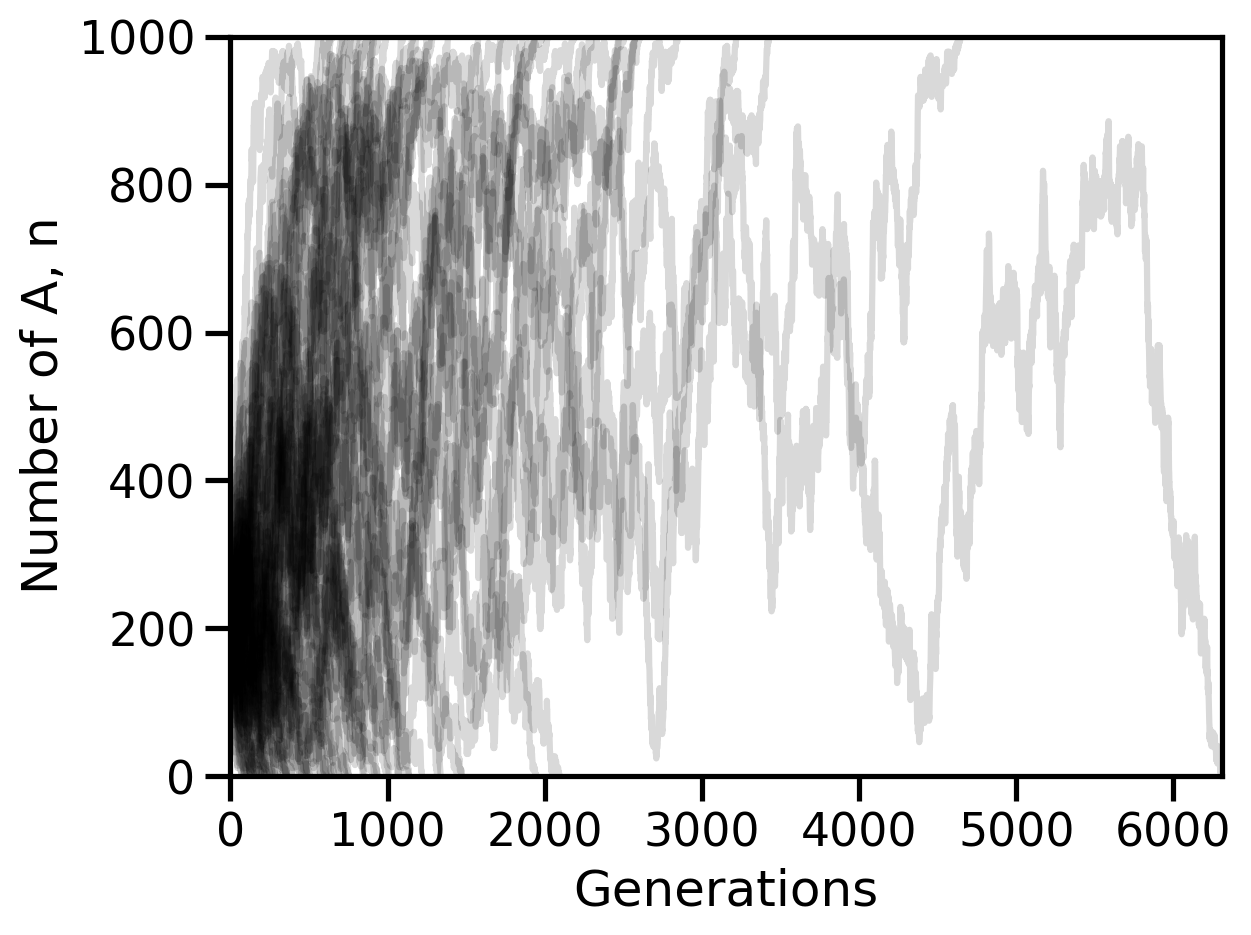

In [27]:
for n_ in n:
    plt.plot(n_, 'k', alpha=0.15)
plt.xlabel('Generations')
plt.ylabel('Number of $A$, $n$')
plt.ylim(0, N)
plt.xlim(0, max(len(n_) for n_ in n));

In [26]:
%timeit simulations_py(200, 1000, 0.1, 100)
%timeit simulations_py(2000, 10000, 0.1, 100)

1.05 s ± 19.6 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
15.7 s ± 637 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


### NumPy

We can do fater with NumPy.

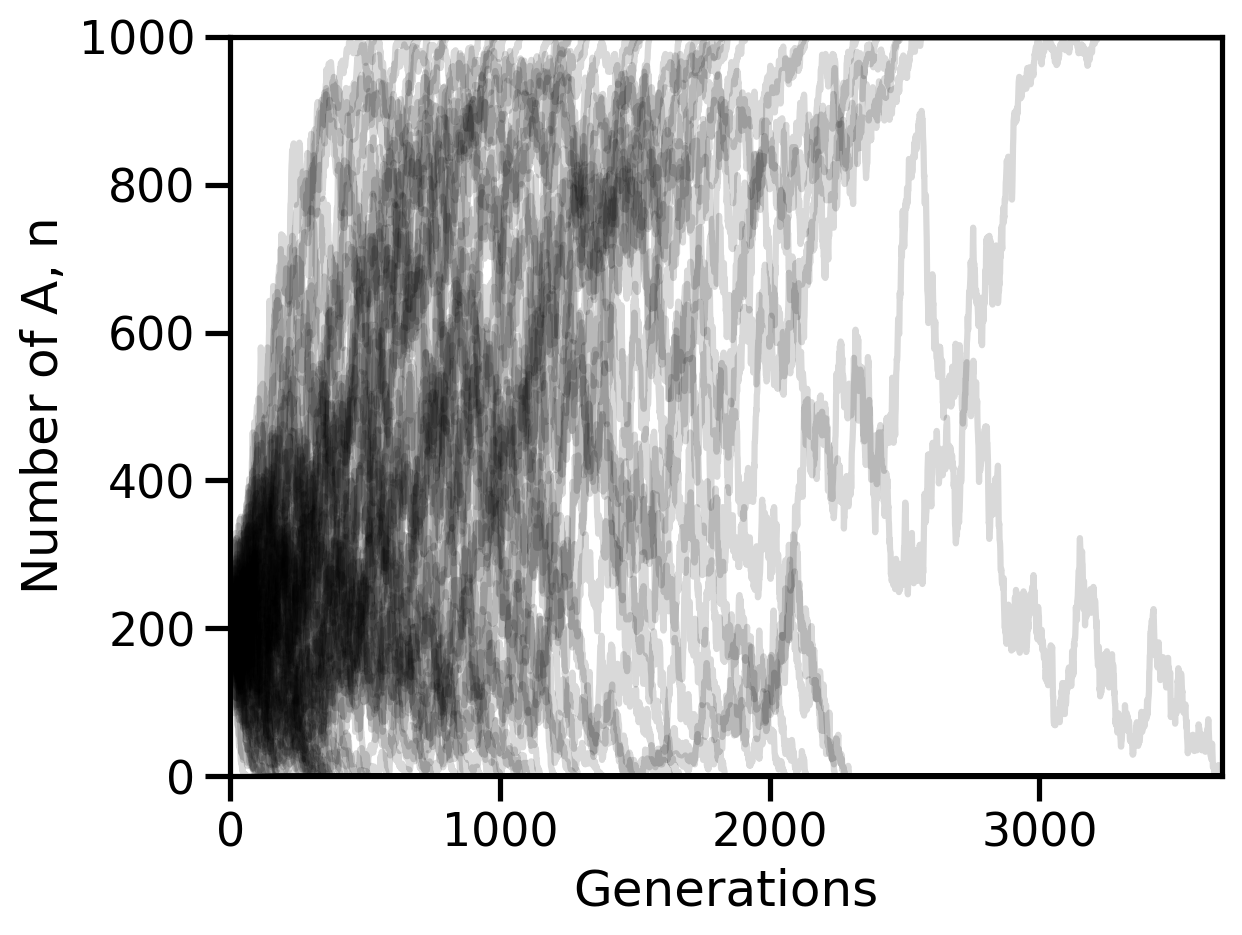

In [28]:
def simulations_np(n0, N, s, repetitions=10, buflen=1000):
    n = np.zeros((buflen, repetitions))
    n[0,:] = n0
    t = 0
    update = (n[t] > 0) & (n[t] < N)
    while update.any():
        t += 1
        p = n[t-1] * (1 + s) / (N + n[t-1] * s)
        if t == n.shape[0]:
            n = np.concatenate((n, np.zeros((buflen, repetitions))))
        n[t, update] = np.random.binomial(N, p[update])
        n[t, ~update] = n[t-1, ~update]
        update = (n[t] > 0) & (n[t] < N)

    return n[:t].copy()

n = simulations_np(n0, N, s, 100)
plt.plot(n, 'k', alpha=0.15)
plt.xlabel('Generations')
plt.ylabel('Number of $A$, $n$')
plt.ylim(0, N)
plt.xlim(0, n.shape[0]);

This is a more sophisticated way to visualize the same result.

The x-axis is still time; the y-axis represents the repitions (or population), and the color denotes the frequency of type $A$, from dark for zero to bright for 1.

The repetitions are ordered by the average frequency of type $A$ over the entire simulation duration, so that simulations with quick fixation of $A$ are at the top, simulations with quick extinction of $A$ are at the bottom, and simulations that took a long time to end are at the middle.

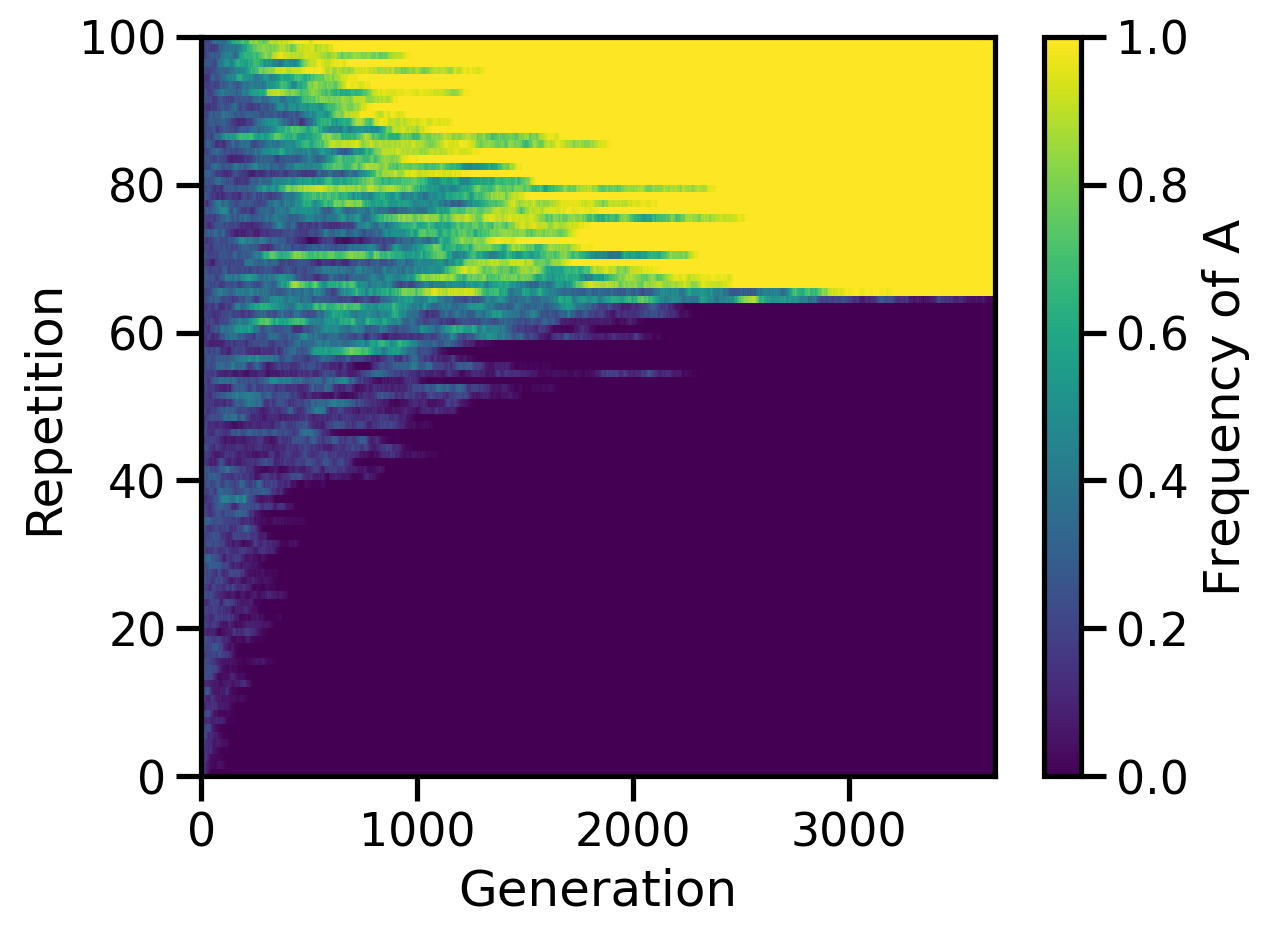

In [29]:
idx = n.mean(axis=0).argsort()
plt.pcolormesh(n[:, idx].T / N)
plt.colorbar(label='Frequency of $A$')
plt.xlabel('Generation')
plt.ylabel('Repetition');

In [13]:
%timeit simulations_np(n0=200, N=1000, s=0.1, repetitions=1000)
%timeit simulations_np(n0=2000, N=10000, s=0.1, repetitions=1000)

18.9 ms ± 802 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)
21.1 ms ± 679 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)


We can see that the NumPy implementation is much faster.

## Fixation probability (stochastic model)

If we want to estimate the fixation probability, we don't actually need to save the entire `n` array.

In [30]:
def fix_prob(n0, N, s, repetitions=10):
    N = int(N)
    n = np.repeat(n0, repetitions)
    n[:] = n0 # broadcasting
    update = (n > 0) & (n < N)
    while update.any():
        p = n * (1 + s) / (N + n * s)
        n[update] = np.random.binomial(N, p[update])
        update = (n > 0) & (n < N)

    return (n == N).mean()

fix_prob(1, 100, 0.1, 100000)

This saves both memory and CPU.

In [45]:
%timeit n = simulations_np(1, 100, 0.1, 100000); (n[-1,:]==N).mean()
%timeit fix_prob(1, 100, 0.1, 100000)

803 ms ± 52.8 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
416 ms ± 14.6 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


Now let's plot the fixation probability for different population sizes; we expect it to converge to the deterministic result $2s$ for large populations.

In [31]:
Ns = np.logspace(1, 6, 100, dtype=int)
s = 0.001
n0 = 1
reps = 1000

pfix = np.array([fix_prob(n0, N, s, reps) for N in Ns])

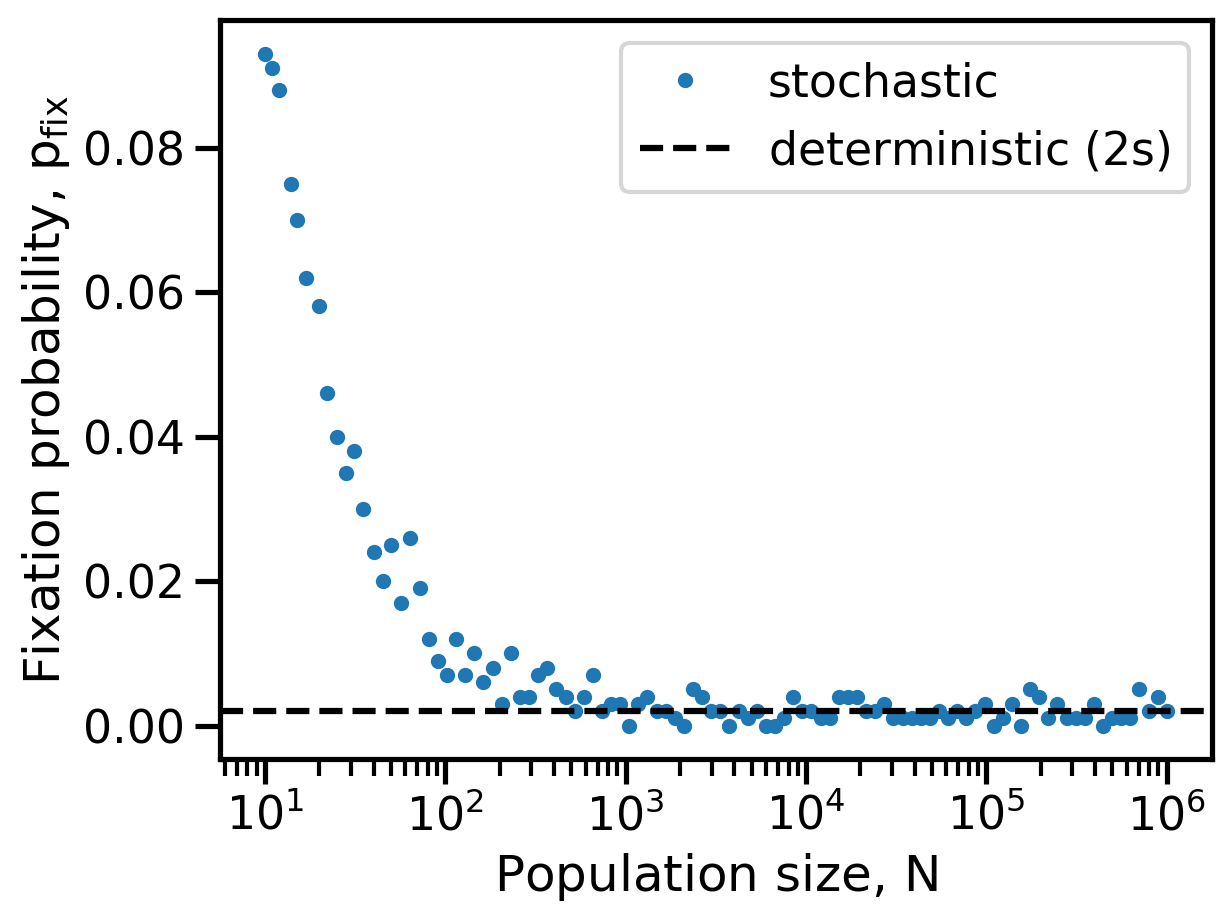

In [39]:
plt.plot(Ns, pfix, '.', label='stochastic')
plt.axhline(2*s, ls='--', color='k', label='deterministic $(2s)$')

plt.xlabel('Population size, $N$')
plt.xscale('log')
plt.ylabel('Fixation probability, $p_{fix}$')
plt.legend();

## Diffusion equation approximation for fixation probability

There is a rather good approximation even for small population sizes.
Using a diffusion equation approximation, [Kimura (1962)](http://www.ncbi.nlm.nih.gov/pmc/articles/PMC1210364/) reached his famous equation:

$$
\frac{1 - e^{-2 n_0 s}}{1 - e^{-2 N s}}
$$

For large $N$, the denominator is roughly 1, and if $s$ is small than we can approximate this by $2s$. 

For a modern derivation see Durrett's [Probability Models for DNA Sequence Evolution](https://services.math.duke.edu/~rtd/Gbook/Gbook.html), ch. 7 (free online).

[![Kimura](https://upload.wikimedia.org/wikipedia/en/4/48/Motoo_Kimura.jpg)](https://en.wikipedia.org/wiki/Motoo_Kimura)

**Motoo Kimura, 1924 - 1994**

In [40]:
def fix_kimura(n0, N, s):
    return np.expm1(-2 * n0 * s) / np.expm1(-2 * N * s)

Note the use of `expm1(x)` which is more precise than `exp(1-x)` for small `x` values.

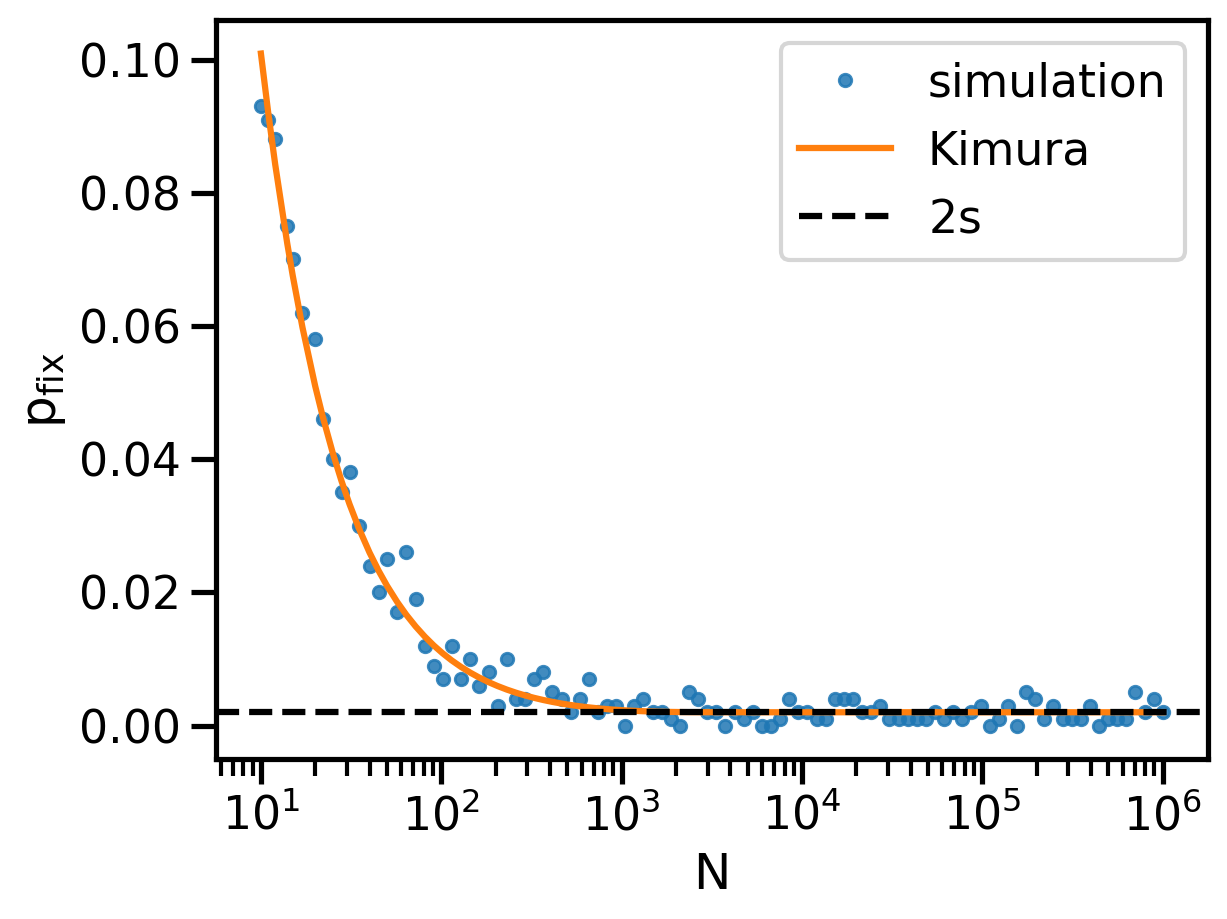

In [43]:
plt.plot(Ns, pfix, '.', alpha=0.85, label='simulation')
plt.plot(Ns, fix_kimura(n0, Ns, s), '-', label='Kimura')
plt.axhline(2*s/(1+s), ls='--', color='k', label='$2s$')

plt.xlabel('N')
plt.xscale('log')
plt.ylabel('$p_{fix}$')
plt.legend();

This approximation does the job very well.

Behold the power of NumPy's `ufunc`:

In [58]:
Ns_ = np.logspace(1, 6, 5000, dtype=np.int64)
%timeit [fix_kimura(n0, N, s) for N in Ns_]
%timeit fix_kimura(n0, Ns_, s)

26.1 ms ± 635 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)
53.7 µs ± 887 ns per loop (mean ± std. dev. of 7 runs, 10000 loops each)


## Numba implementation

[Numba](http://numba.pydata.org/) is a JIT compiler for Python and NumPy built over LLVM

In [46]:
import numba

fix_kimura_nm = numba.jit(fix_kimura)
fix_kimura_nm(n0, N, s); # burn-in for the jit to work

In [47]:
Ns = np.logspace(1, 6, 100, dtype=float)
%timeit fix_kimura(n0, Ns, s)
%timeit fix_kimura_nm(n0, Ns, s)

7.82 µs ± 81.5 ns per loop (mean ± std. dev. of 7 runs, 100,000 loops each)
2.34 µs ± 24.8 ns per loop (mean ± std. dev. of 7 runs, 100,000 loops each)


In [48]:
Ns = np.logspace(1, 6, 10000, dtype=float)
%timeit fix_kimura(n0, Ns, s)
%timeit fix_kimura_nm(n0, Ns, s)

100 µs ± 5.33 µs per loop (mean ± std. dev. of 7 runs, 10,000 loops each)
92.1 µs ± 3.5 µs per loop (mean ± std. dev. of 7 runs, 10,000 loops each)


## Fixation time (stochastic)

Now we will focus on the *time* it takes for the fixation of one of the type to occur.

In [49]:
def fix_time(n0, N, s, repetitions=10):
    N = int(N)
    n = np.repeat(n0, repetitions)
    T = np.repeat(np.inf, repetitions)
    
    t = 0
    n[:] = n0
    update = (n > 0) & (n < N)
    while update.any():        
        p = n * (1 + s) / (N + n * s)
        n[update] = np.random.binomial(N, p[update])
        update = (n > 0) & (n < N)
        t += 1
        T[~update] = np.minimum(T[~update], t)
    return n == N, T

In [50]:
n0 = 10
N = 1000
s = 0.01
fixations, times = fix_time(n0, N, s, 100000)

We'll plot the distribution of waiting time for fixation of $A$ and for extinction of $A$.

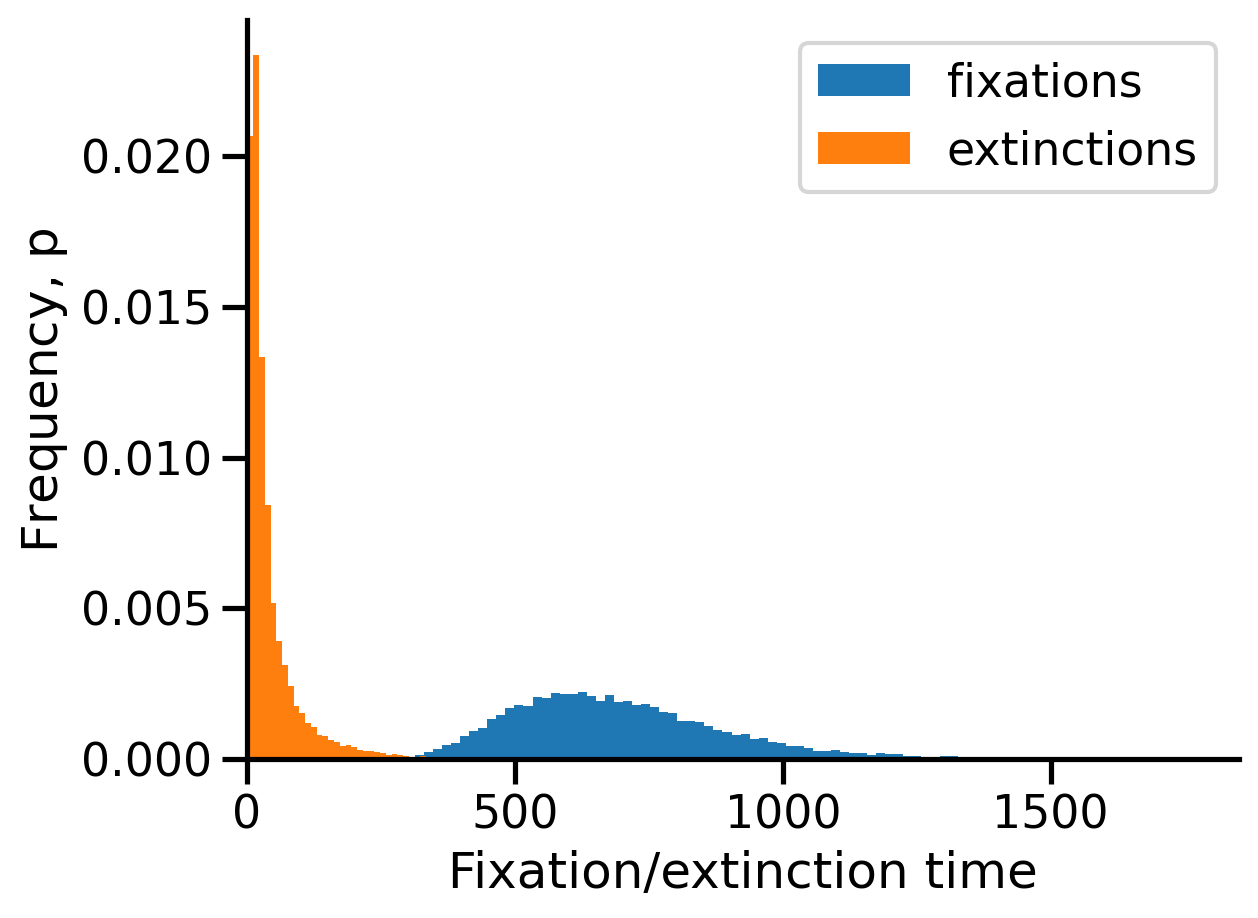

In [51]:
fig, ax = plt.subplots()

ax.hist(times[fixations], bins=100, density=True, label='fixations')
ax.hist(times[~fixations], bins=100, density=True, label='extinctions')

ax.set(
    xlim=(0, -4 * np.log(n0/N) / np.log(1+s)),
    xlabel='Fixation/extinction time',
    ylabel='Frequency, $p$'
)
ax.legend()
sns.despine()

### Deterrministic approximation

We can now compare the expected fixation time to an approximation derived from the deterministic model we studied before.

In [52]:
def mean_std_fix_time(fixations, times):
    fix_times = times[fixations]
    return fix_times.mean(), fix_times.std(ddof=1)

n0 = 1
Ns = np.logspace(1, 8, 50, dtype=int)
s = 0.01
fix_times = np.array([
    mean_std_fix_time(*fix_time(n0, N, s, 10000)) 
    for N in Ns
])

The deterministic approximation is (see above)
$$
t = -2 \frac{log(p_0)}{log{(1+s)}}
$$

In [53]:
def T_haldane(n0, Ns, s):
    return -2 * np.log(n0/Ns) / np.log(1+s)

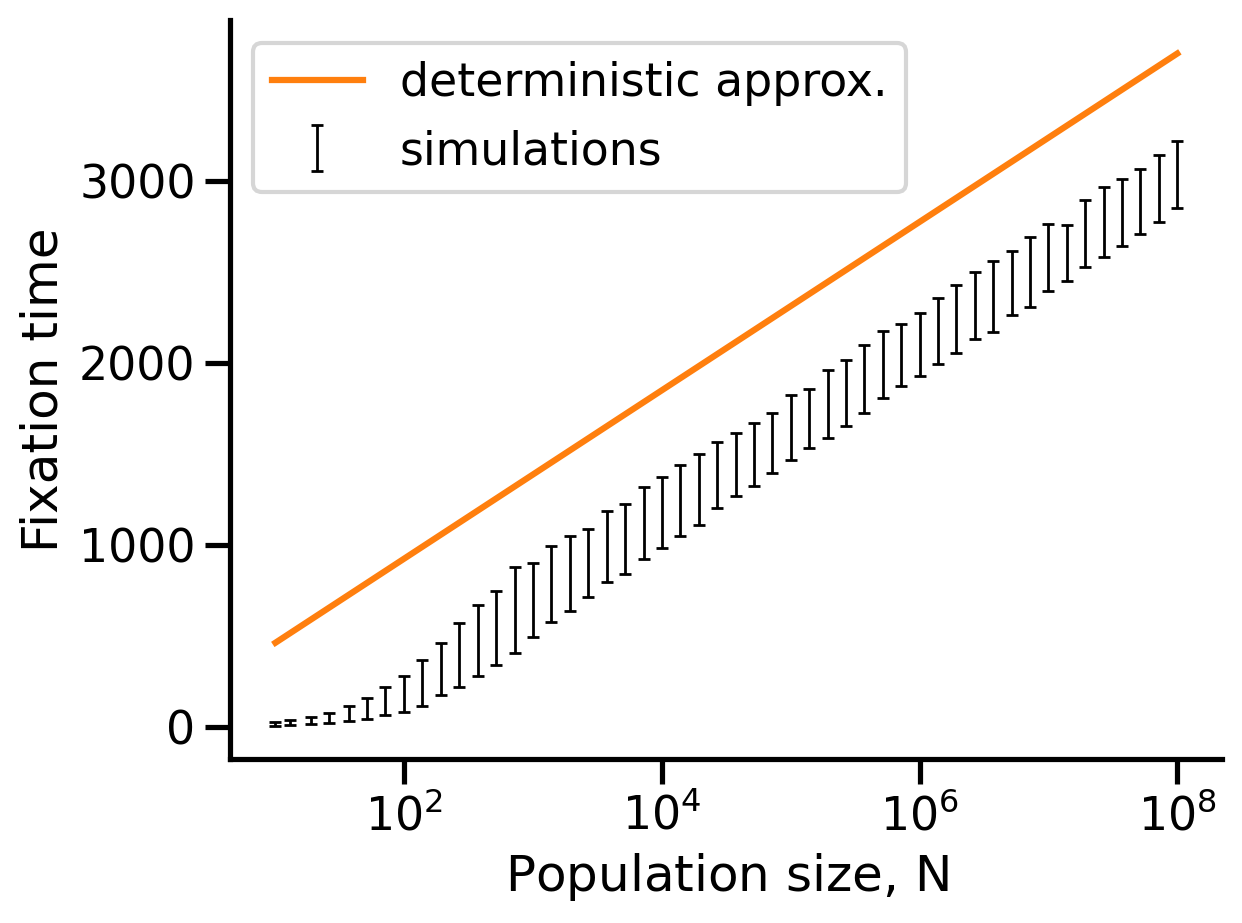

In [54]:
plt.errorbar(Ns, fix_times[:,0], yerr=fix_times[:,1], 
             capsize=2, capthick=1, lw=0, label='simulations',
             ecolor='k', elinewidth=1)
plt.plot(Ns, T_haldane(n0, Ns, s), label='deterministic approx.')
plt.xscale('log')
plt.xlabel('Population size, $N$')
plt.ylabel('Fixation time')
plt.legend()
sns.despine()

We can see that the deterministic approximation constantly over estimates the fixation time.

Can we have a better approximation?

### Diffusion equation approximation for fixation time

Another approximation of the fixation time is based on a diffusion equation and is given in [Kimura and Ohta 1969](http://www.pubmedcentral.nih.gov/articlerender.fcgi?artid=1212239) (eq. 17). It assumes a population size of $2N$ gametes and selection advantage of $s/2$ rather then $N$ and $s$, therefore I'm changing $s=2s$ and $N=N/2$. Also, it has the initial frequency as $x$, so we define $x=n_0/N$.

$$
I_1(x) = \frac{1 - e^{-2 n_0 s} - e^{-2Ns(1-x)} + e^{-2Ns}}{x(1-x)} \\
I_2(x) = \frac{(e^{2Nsx} - 1) (1 - e^{-2Ns(1-x)})}{x(1-x)} \\
J_1 = \frac{1}{s(1-e^{-2Ns})} \int_{x}^{1}{I_1(y) dy} \\
J_2 = \frac{1}{s(1-e^{-2Ns})} \int_{0}^{x}{I_2(y) dy} \\
u = \frac{1 - e^{-2Nsx}}{1 - e^{-2Ns}} \\
T_{fix} = J1 + \frac{1-u}{u} J_2
$$

For a modern derivation see Durrett's [Probability Models for DNA Sequence Evolution](https://services.math.duke.edu/~rtd/Gbook/Gbook.html), ch. 7 (free online).

Here we need to integrate some functions, we'll do this using `scipy.integrate.quad`. 

`functools.partial` reduces the number of arguments a function expects, effectively freezing some of them - mathematically, it creates a projection.

`np.vectorize` is a decorator that converts a scalar function to an array function, giving it the `ufunc` super powers.

In [55]:
from scipy.integrate import quad 
from functools import partial

def integral(f, N, s, a, b):
    f = partial(f, N, s)    
    return quad(f, a, b)[0]

In [56]:
def I1(N, s, x):
    if x == 1:
        return 0
    return (1 - np.exp(-2*N*s*x) - np.exp(-2 * N * s * (1 - x)) + np.exp(-2 * N *s)) / (x*(1-x))

def I2(N, s, x):
    if x == 0:
        return 0
    return -np.expm1(2 * N * s * x) * np.expm1(-2 * N * s * x) / (x * (1 - x))

@np.vectorize
def T_kimura(n0, N, s):
    x = n0 / N
    J1 = -1.0 / (s * np.expm1(-2 * N * s)) * integral(I1, N, s, x, 1)
    u = np.expm1(-2 * N * s * x) / np.expm1(-2 * N * s)
    J2 = -1.0 / (s * np.expm1(-2 * N *s)) * integral(I2, N, s, 0, x)
    return J1 + ((1 - u) / u) * J2

assert 254 < T_kimura(1, 1e6, 0.1) < 255

Behold the power of `np.vectorize`.

In [65]:
Ns = np.logspace(1, 6, 100)
%timeit np.array([T_kimura(n0, N, s) for N in Ns])
%timeit T_kimura(n0, Ns, s)

337 ms ± 30.3 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
116 ms ± 4.55 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


Let's compare the simulation results with the two approximations:

In [57]:
n0 = 1
Ns = np.logspace(1, 8, 50, dtype=int)
s = 0.01

fix_time_kimura = T_kimura(n0, Ns, s)
fix_time_haldane = T_haldane(n0, Ns, s)

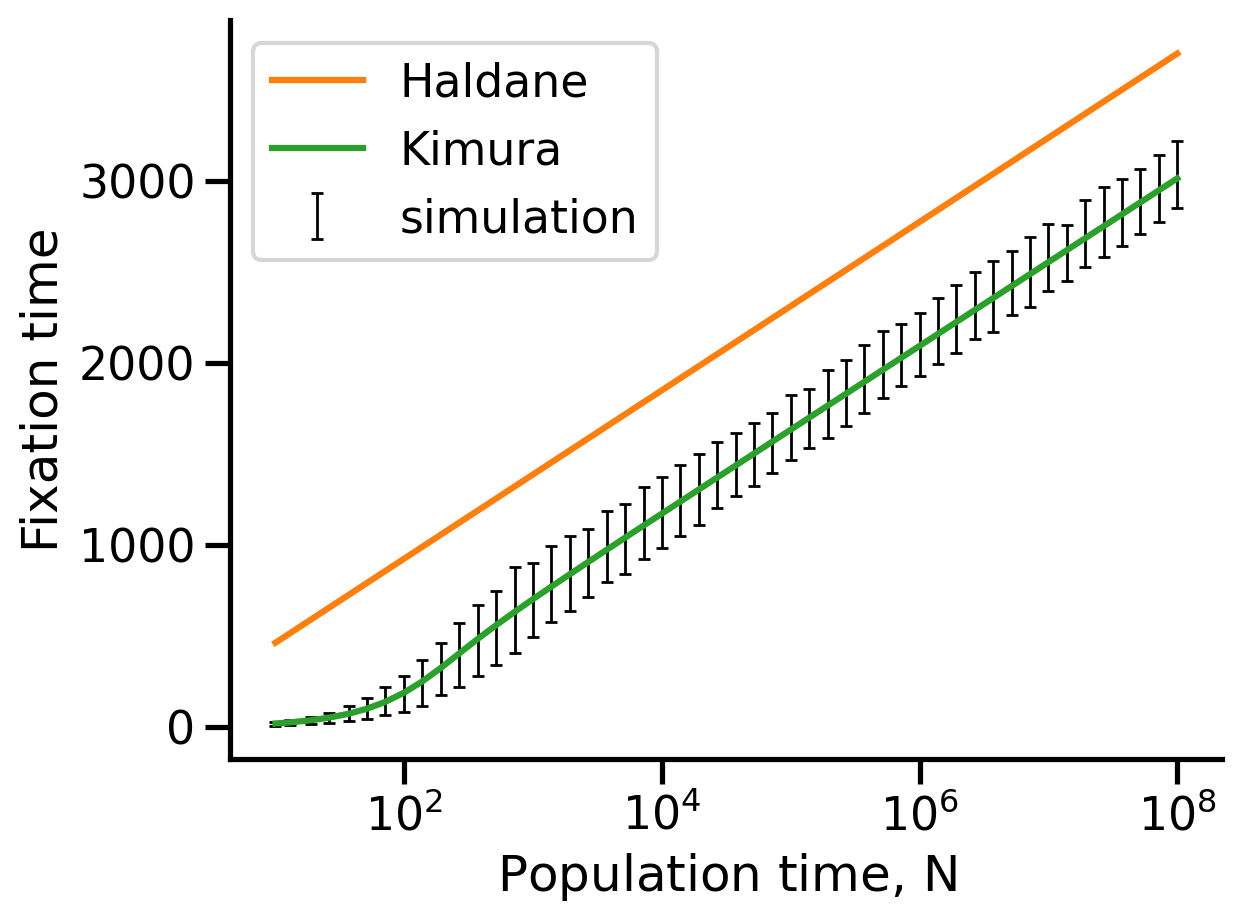

In [58]:
plt.errorbar(Ns, fix_times[:,0], yerr=fix_times[:,1], 
             capsize=2, capthick=1, lw=0, label='simulation',
             ecolor='k', elinewidth=1)
plt.plot(Ns, fix_time_haldane, label='Haldane')
plt.plot(Ns, fix_time_kimura, label='Kimura')

plt.xscale('log')
plt.xlabel('Population time, $N$')
plt.ylabel('Fixation time')
plt.legend()
sns.despine()

Kimura's diffusion approximation is fantastic.

# Colophon
This notebook was written by [Yoav Ram](http://www.yoavram.com) and is part of the [Models in Population Biology](http://modelspopbiol.yoavram.com) course at Tel Aviv University.

This work is licensed under a CC BY-NC-SA 4.0 International License.